In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from scipy import stats

pal1 = sns.color_palette("pastel")
sns.set_palette(pal1)

### Задача предсказания стоимости страховки 

Во многих странах медицинское страхование не является бесплатным - напротив, это дорогое удовольствие, доступное не каждому гражданину. Стоимость мед. страховки обычно рассчитывается индивидуально, в зависимости от характеристик состояния здоровья клиента. 

Представленная ниже [база данных](https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction) была сформирована и предоставлена одной из медицинских страховых компаний Индии. Она представляет из себя данные об около 1000 пациентах - их состоянии здоровья и годовой стоимости страховки (в рупиях). В нашем исследовании мы стремимся с помощью линейной регрессии предсказать стоимость страховки по заданным характеристикам.

In [4]:
data = pd.read_csv('Medicalpremium.csv')

В датасете представлены следующие признаки:
1. Возраст (лет)
2. Наличие диабета - (1 - есть, 0 - не выявлен)
3. Проблемы с давлением - (1 - проблемв есть, 0 - проблем не наблюдалось)
4. Операции по пересадке органов / переливанию крови (1 - были, 0 - не было)
5. Наличие хронических заболеваний (1 - есть, 0 - не выявлены)
6. Рост (см)
7. Вес (кг)
8. Наличие аллергий (1 - есть, 0 - не выявлены)
9. История раковых заболеваний в семье (1 - рак был выявлен у кого-то из родственников, 0 - рак не был выявлен)
10. Количество серьезных операций, перенесенных в течение жизни (категориальная переменная)
11. Годовая стоимость медицинской страховки (в рупиях) - целевая переменная

In [4]:
data

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


Раз уж нам доступна информация о росте и весе, добавим Body Mass Index, рассчитываемый по формуле:
<br/>
<br/>
$$BMI = \frac{Weight (cm)}{(Height (m)) ^ 2}$$
<br/>
Предположительно, такой признак будет более показателен для оценки состояния здоровья клиента страховой компанией.

In [5]:
data['BodyMassIndex'] = data.apply(lambda x: x['Weight'] / (x['Height'] / 100) ** 2 , axis=1)

### Предварительный анализ данных
Прежде чем строить линейную регрессию, посмотрим на распределение некоторых признаков

#### Проверим баланс классов для дамми и категориальных переменных

In [6]:
data['Diabetes'].value_counts()

0    572
1    414
Name: Diabetes, dtype: int64

In [12]:
data['BloodPressureProblems'].value_counts()

0    524
1    462
Name: BloodPressureProblems, dtype: int64

In [13]:
data['AnyTransplants'].value_counts()

0    931
1     55
Name: AnyTransplants, dtype: int64

In [14]:
data['AnyChronicDiseases'].value_counts()

0    808
1    178
Name: AnyChronicDiseases, dtype: int64

In [15]:
data['KnownAllergies'].value_counts()

0    774
1    212
Name: KnownAllergies, dtype: int64

In [16]:
data['HistoryOfCancerInFamily'].value_counts()

0    870
1    116
Name: HistoryOfCancerInFamily, dtype: int64

In [17]:
data['NumberOfMajorSurgeries'].value_counts()

0    479
1    372
2    119
3     16
Name: NumberOfMajorSurgeries, dtype: int64

#### Средняя стоимость страховки в зависимости от значений дамми-переменных:

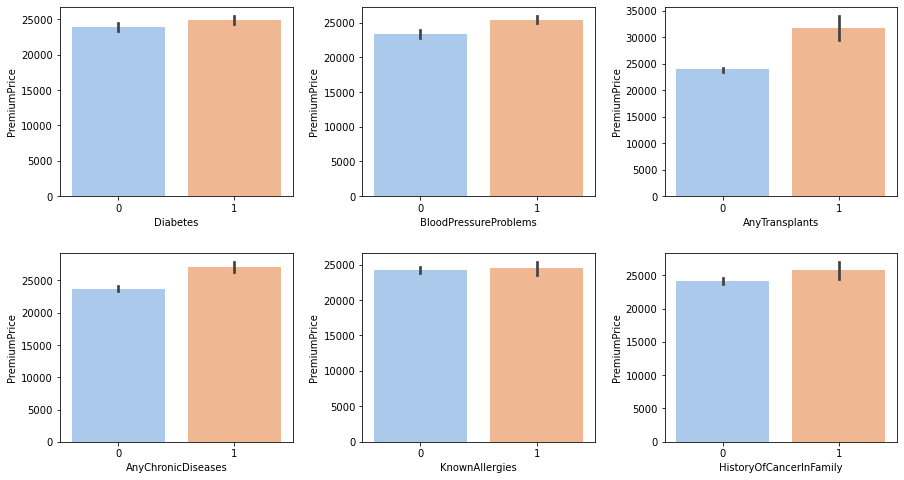

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

sns.barplot(data=data, x='Diabetes', y='PremiumPrice', ax=axs[0, 0])
sns.barplot(data=data, x='BloodPressureProblems', y='PremiumPrice', ax=axs[0, 1])
sns.barplot(data=data, x='AnyTransplants', y='PremiumPrice', ax=axs[0, 2])
sns.barplot(data=data, x='AnyChronicDiseases', y='PremiumPrice', ax=axs[1, 0])
sns.barplot(data=data, x='KnownAllergies', y='PremiumPrice', ax=axs[1, 1])
sns.barplot(data=data, x='HistoryOfCancerInFamily', y='PremiumPrice', ax=axs[1, 2]);

#### Ящичковые диаграммы распределения непрерывных переменных 

In [11]:
def boxplot_features(data):
    fig, axs = plt.subplots(2, 2, figsize=(13,8))
    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    sns.boxplot(ax=axs[0, 0], data=data['Weight'])
    axs[0, 0].set_title('Weight Distribution')

    sns.boxplot(ax=axs[0, 1], data=data['Height'])
    axs[0, 1].set_title('Height Distribution')

    sns.boxplot(ax=axs[1, 0], data=data['BodyMassIndex'])
    axs[1, 0].set_title('Body Mass Index Distribution')

    sns.boxplot(ax=axs[1, 1], data=data['Age'])
    axs[1, 1].set_title('Age Distribution');


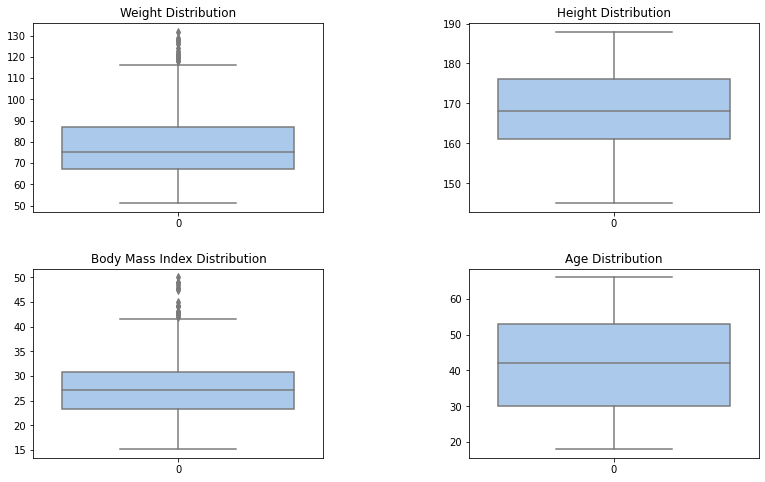

In [12]:
boxplot_features(data)

Как мы видим, у параметра веса и, соответственно, параметра BMI присутствуют выбросы в выборке. Попробуем избавиться от них путем отсечения веса по верхней границе 115 кг.

In [6]:
Weight_outlier = np.where(data['Weight'] >= 115)
data_upd = data.drop(Weight_outlier[0], inplace = False)

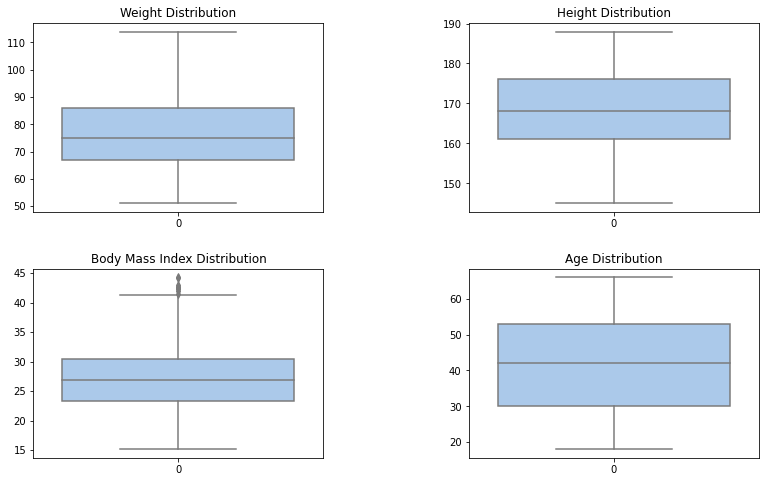

In [14]:
boxplot_features(data_upd)

Проверим, что мы не выкинули слишком много наблюдений:

In [221]:
len(data_upd)

967

Напоследок посмотрим на распределение стоимости страховки:

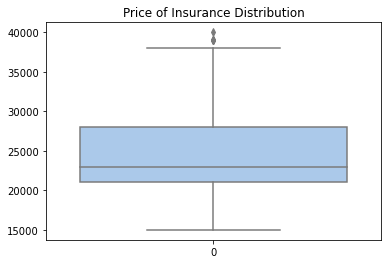

In [15]:
ax = sns.boxplot(data=data['PremiumPrice'])
ax.set_title('Price of Insurance Distribution');

#### Диаграммы рассеяния

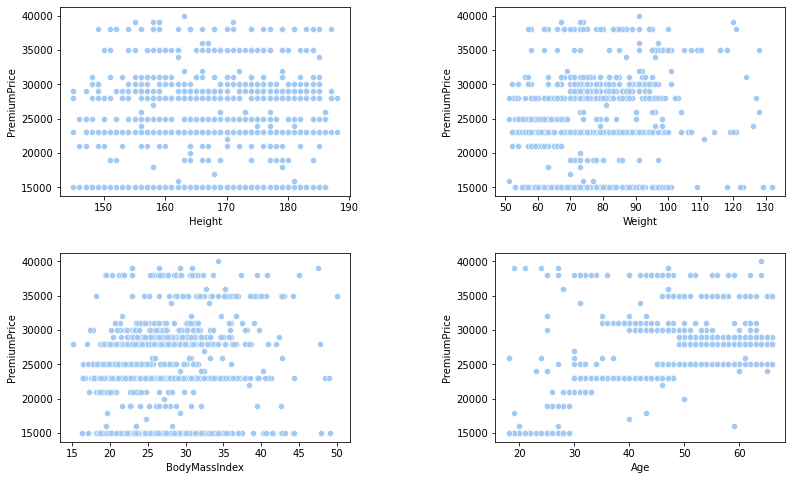

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(13,8))
fig.subplots_adjust(hspace=0.3, wspace=0.5)
sns.scatterplot(data=data, x='Height', y='PremiumPrice', ax=axs[0, 0])
sns.scatterplot(data=data, x='Weight', y='PremiumPrice', ax=axs[0, 1])
sns.scatterplot(data=data, x='BodyMassIndex', y='PremiumPrice', ax=axs[1, 0])
sns.scatterplot(data=data, x='Age', y='PremiumPrice', ax=axs[1, 1]);

#### Матрица корреляций

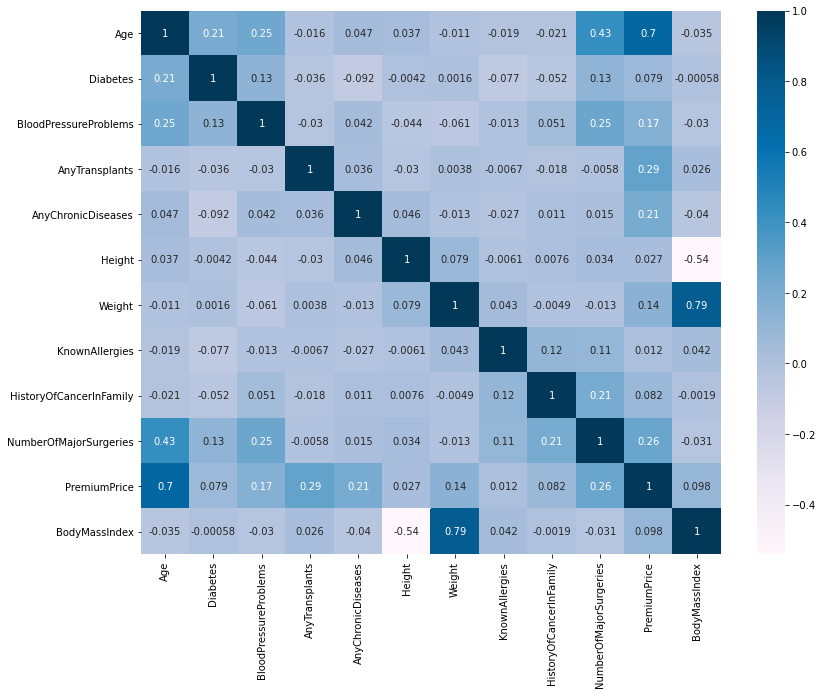

In [19]:
plt.subplots(figsize=(13, 10))
sns.heatmap(data_upd.corr(), annot=True, cmap='PuBu');

## Построение линейной регрессии

У нас есть один категориальный признак - количество перенесенных серьезных операций. Закодируем его через дамми-переменные, за базовую категорию возьмем 0 операций.

In [7]:
data_upd2 = pd.get_dummies(data_upd, columns=['NumberOfMajorSurgeries'], drop_first=True)

In [8]:
data_upd2

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,PremiumPrice,BodyMassIndex,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,155,57,0,0,25000,23.725286,0,0,0
1,60,1,0,0,0,180,73,0,0,29000,22.530864,0,0,0
2,36,1,1,0,0,158,59,0,0,23000,23.634033,1,0,0
3,52,1,1,0,1,183,93,0,0,28000,27.770313,0,1,0
4,38,0,0,0,1,166,88,0,0,23000,31.934969,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,15000,23.458562,0,0,0
982,64,1,1,0,0,153,70,0,0,28000,29.903029,0,0,1
983,56,0,1,0,0,155,71,0,0,29000,29.552549,1,0,0
984,47,1,1,0,0,158,73,1,0,39000,29.242109,1,0,0


Разделим переменные на фичи ($X$) и таргет ($Y$). Также, уберем переменные веса и роста из регрессии во избежание мультиколлинеарности (из-за корреляции с Body Mass Index).

In [35]:
data_preproc = data_upd2.drop(columns=['PremiumPrice', 'Weight', 'Height'])
x = data_preproc.to_numpy()
y = data_upd2['PremiumPrice'].to_numpy()

### Идентификация модели
$$ PremiumPrice = \beta_0 + \beta_1 * Age + \beta_2 * Diabetes + \beta_3 * BloodPressureProblems + \beta_4 * AnyTransplants + 
    \beta_5 * AnyChronicDiseases + $$
    <br/>
    $$+ \beta_6 * KnownAllergies + \beta_7 * HistoryOfCancerInFamily + 
    \beta_8 * BodyMassIndex + \beta_9 * NumberOfMajorSurgeries_1 + $$
    <br/>
    $$ + \beta_{10} * NumberOfMajorSurgeries_2 + \beta_{11} * NumberOfMajorSurgeries_3$$

In [162]:
print(x.shape, y.shape)

(967, 12) (967,)


Добавим свободный коэффициент в регрессию ($\beta_0$):

In [36]:
x = sm.add_constant(x)

Построим модель, коэффиценты подбираются методом наименьших квадратов:

In [37]:
model = sm.OLS(y, x)

In [38]:
results = model.fit()

In [39]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     155.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          4.90e-204
Time:                        22:36:07   Log-Likelihood:                -9317.6
No. Observations:                 967   AIC:                         1.866e+04
Df Residuals:                     955   BIC:                         1.872e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5614.2309    748.218      7.503      0.0

### Преобразование Бокса-Кокса

C:\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


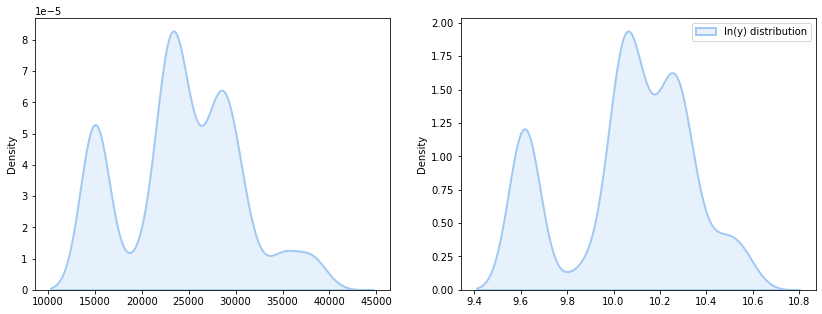

In [42]:
fitted_data = stats.boxcox(y, lmbda=0)
fig, ax = plt.subplots(1, 2)

sns.distplot(y, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "y distribution", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "ln(y) distribution", ax = ax[1])
 
plt.legend(loc = "best")
 
fig.set_figheight(5)
fig.set_figwidth(14)

## Регрессия с логарифмом


In [43]:
data_preproc = data_upd2.drop(columns=['PremiumPrice', 'Height', 'Weight'])
x = data_preproc.to_numpy()
y_log = fitted_data
x = sm.add_constant(x)
model_log = sm.OLS(fitted_data, x)
results_log = model_log.fit()
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     169.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          1.43e-215
Time:                        22:36:52   Log-Likelihood:                 420.62
No. Observations:                 967   AIC:                            -817.2
Df Residuals:                     955   BIC:                            -758.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2485      0.032    292.174      0.0

### Тест максимального правдоподобия

In [46]:
full_ll = results.llf
print(full_ll)

reduced_ll = results_log.llf
print(reduced_ll)

LR_statistic = -2*(reduced_ll-full_ll)
print(LR_statistic)

p_val = stats.chi2.sf(LR_statistic, 2)
print(p_val)


420.6216791700267
-19476.499073780946
1.0


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


C:\python\lib\site-packages\statsmodels\graphics\regressionplots.py:565: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


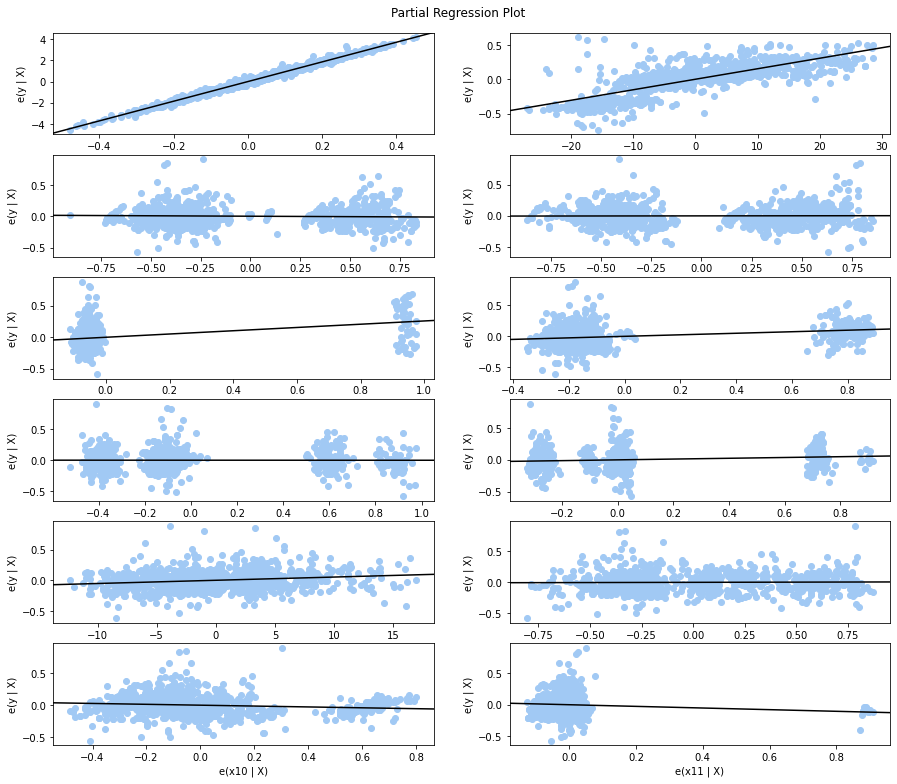

In [20]:
fig = sm.graphics.plot_partregress_grid(results_log)
fig.set_figheight(12)
fig.set_figwidth(15);